In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


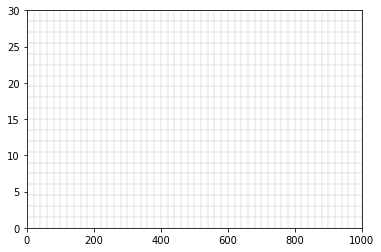

In [4]:
def make_grid(nlay, nrow, ncol, lx, top0):
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)

    delr = lx / ncol
    delc = 1.
    delv = top0 / nlay
    top[:, :] = top0
    
    for k in range(nlay):
        tp = top0
        if k > 0:
            tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    return (delr, delc, top, botm)

nlay = 20
nrow = 1
ncol = 50
lx = 1000.
top0 = 30.
delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)
mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                         delr=delr, delc=delc, top=top, botm=botm)
pxs = flopy.plot.PlotCrossSection(modelgrid=mg, line={'row': 0})
pxs.plot_grid(alpha=1., lw=0.1)

In [5]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

In [14]:
def get_model(ws, name, nlay, nrow, ncol, lx, top0, time_end,
              hydraulic_conductivity, specific_storage, porosity, 
              alpha_l, alpha_t,
              cfresh, csalt,
              nper=100,
              hstrt=None, cstrt=None,
              converge_continue=False,
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)

    nstp = 1
    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if hstrt is None:
        hstrt = top0
    else:
        hstrt = {'filename': 'hstrt.bin', 'factor': 1.0, 
                 'data': hstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=0,
                                  k=hydraulic_conductivity)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    hhformulation = True
    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)
    
    # output control
    saverecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {'filename': 'cstrt.bin', 'factor': 1.0, 
                 'data': cstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    #dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=0.,
    #                              alh=alpha_l, ath1=alpha_t)

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

    # output control
    saverecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'ALL')],
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [15]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    return head, conc, spdis, times

In [16]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

In [114]:
def make_figure(gwf, head, conc, spdis, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.set_aspect('equal')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    # 50% seawater line
    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.array([.5])* csalt, 
                      linestyles = ['-'], colors=['k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.zcellcenters
        X, Y = np.meshgrid(x, y[:, 0, 0])
        u = spdis['qx']
        u = u.reshape(X.shape)
        v = spdis['qz']
        v = v.reshape(X.shape)
        sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
    
    if ax2dict is not None:
        with plt.rc_context({'axes.edgecolor':'white', 
                             'axes.facecolor':'yellow',
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'font.size': 8,
                             'axes.labelcolor': 'white',
                             }):
            if 'limits' in ax2dict:
                limits = ax2dict['limits']
            else:
                limits = [0.15, 0.22, 0.2, 0.2]
            xdata = ax2dict['xdata']
            ydata = ax2dict['ydata']
            ax2 = fig.add_axes(limits)
            ax2.plot(xdata, ydata, 'k-')
            if 'xlim' in ax2dict:
                ax2.set_xlim(*ax2dict['xlim'])
            if 'ylim' in ax2dict:
                ax2.set_ylim(*ax2dict['ylim'])
            if 'xlabel' in ax2dict:
                ax2.set_xlabel(ax2dict['xlabel'])
            if 'ylabel' in ax2dict:
                ax2.set_ylabel(ax2dict['ylabel'])
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [115]:
def make_movie(figfile, anmfile):
    from subprocess import check_output
    vcodec = 'libx264'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vb', '20M',
                           '-vcodec', vcodec,
                           '-pix_fmt', 'yuv420p',
                           anmfile])    

In [19]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# Blob

In [120]:
gfact = 1
nlay = int(100 * gfact)
nrow = 1
ncol = int(100 * gfact)
lx = 100.
top0 = 100.
nper = 200
time_end = 2000.
cfresh = 0.
csalt = 35.
recharge = 18.25 / 1000. / 365. # convert mm/yr to m/yr to m/day
porosity = 0.20
hydraulic_conductivity = 1. # m/day
specific_storage = 0.008 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter
#cstrt = cfresh * np.ones((nlay, nrow, ncol), dtype=np.float)
#cstrt[40:60, :, 40:60] = csalt

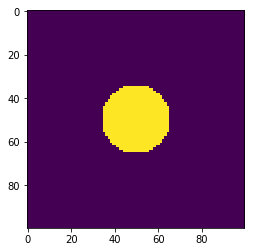

In [121]:
import flopy.discretization as fgrid
from shapely.geometry import Polygon
from flopy.utils.gridintersect import GridIntersect
sgr = fgrid.StructuredGrid(np.ones(100), np.ones(100), top=None, botm=None)

theta = np.arange(0., 2*np.pi, 0.2)
radius = 15.
x = radius * np.cos(theta) + lx / 2.
y = radius * np.sin(theta) + top0 / 2.
#circle_poly = [(x, y) for x, y in zip(x, y)]
p = Polygon(shell=[(x, y) for x, y in zip(x, y)])
ix = GridIntersect(sgr)
result = ix.intersect_polygon(p)
#sgr.plot()
cstrt = np.zeros((nlay, nrow, ncol))
for k, j in result['cellids']:
    cstrt[k, 0, j] = csalt
plt.imshow(cstrt[:, 0, :])

In [122]:
ws0 = 'temp/pxx_gwt_blob'
name = 'blob'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx,
                 top0, time_end, 
                 hydraulic_conductivity, specific_storage, porosity, 
                 alpha_l, alpha_t,
                 cfresh, csalt, nper=nper, cstrt=cstrt,
                 verbosity_level=1)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package blob.gwfgwt...
  writing model gwf_blob...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package oc...
  writing model gwt_blob...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package mst...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.5 03/31/2019
                               ***DEVELOP MODE***

  MODFLOW 6 compiled Sep 20 2019 19:35:25 with GFORTRAN compiler (ver. 8.

 Solving:  Stress period:   125    Time step:     1
 Solving:  Stress period:   126    Time step:     1
 Solving:  Stress period:   127    Time step:     1
 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   129    Time step:     1
 Solving:  Stress period:   130    Time step:     1
 Solving:  Stress period:   131    Time step:     1
 Solving:  Stress period:   132    Time step:     1
 Solving:  Stress period:   133    Time step:     1
 Solving:  Stress period:   134    Time step:     1
 Solving:  Stress period:   135    Time step:     1
 Solving:  Stress period:   136    Time step:     1
 Solving:  Stress period:   137    Time step:     1
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   139    Time step:     1
 Solving:  Stress period:   140    Time step:     1
 Solving:  Stress period:   141    Time step:     1
 Solving:  Stress period:   142    Time step:     1
 Solving:  Stress period:   143    Time step:     1
 Solving:  S

In [123]:
# load results
head0, conc0, spdis0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_blob')

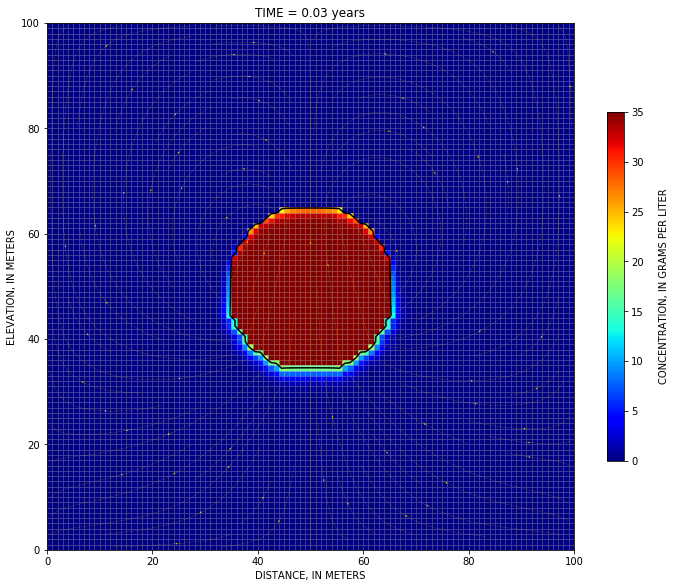

In [124]:
kper = 0
ax = make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
                 times0[kper], top0, streamplot=True)

In [125]:
make_png = True
if make_png:

    pngdir = os.path.join(ws0, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc0.shape[0], 1)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
                    times0[kper], top0,
                    streamplot=True, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

writing temp/pxx_gwt_blob/png/img0.png
writing temp/pxx_gwt_blob/png/img1.png
writing temp/pxx_gwt_blob/png/img2.png
writing temp/pxx_gwt_blob/png/img3.png
writing temp/pxx_gwt_blob/png/img4.png
writing temp/pxx_gwt_blob/png/img5.png
writing temp/pxx_gwt_blob/png/img6.png
writing temp/pxx_gwt_blob/png/img7.png
writing temp/pxx_gwt_blob/png/img8.png
writing temp/pxx_gwt_blob/png/img9.png
writing temp/pxx_gwt_blob/png/img10.png
writing temp/pxx_gwt_blob/png/img11.png
writing temp/pxx_gwt_blob/png/img12.png
writing temp/pxx_gwt_blob/png/img13.png
writing temp/pxx_gwt_blob/png/img14.png
writing temp/pxx_gwt_blob/png/img15.png
writing temp/pxx_gwt_blob/png/img16.png
writing temp/pxx_gwt_blob/png/img17.png
writing temp/pxx_gwt_blob/png/img18.png
writing temp/pxx_gwt_blob/png/img19.png
writing temp/pxx_gwt_blob/png/img20.png
writing temp/pxx_gwt_blob/png/img21.png
writing temp/pxx_gwt_blob/png/img22.png
writing temp/pxx_gwt_blob/png/img23.png
writing temp/pxx_gwt_blob/png/img24.png
writing te